<a href="https://colab.research.google.com/github/SadoukHamzaTarik/Calibration_test/blob/main/Copie_de_ArBert_AuSTR_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing different libraries
!pip install datasets
!pip install transformers
!pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00


In [2]:
#importing packages
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from torch.utils.data import DataLoader
from transformers import Trainer
import torch
import evaluate
import random
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [3]:
#model specification
checkpoint = "UBC-NLP/ARBERT"
checkpoint_directory = "ARBERT"
n_classes = 3

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/ARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#Dataset specification (ans-stance)
raw_datasets = load_dataset("bigIR/AuSTR")
dataset_directory = "AuSTR"
def tokenize_function(example):
    return tokenizer(
        example["rumor_tweet_text"],
        example["authority_tweet_text"],
        truncation=True,
        padding="max_length",
        max_length=512)
#Dataset tokenization
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["rumor_tweet_text","authority_tweet_text","rumor_label","rumor_tweet_id","authority_tweet_id"])
tokenized_datasets = tokenized_datasets.rename_column("stance","labels")
tokenized_datasets = tokenized_datasets.with_format("torch")
tokenized_datasets

README.md:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

AuSTR_train.tsv:   0%|          | 0.00/321k [00:00<?, ?B/s]

AuSTR_dev.tsv:   0%|          | 0.00/112k [00:00<?, ?B/s]

AuSTR_test.tsv:   0%|          | 0.00/98.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/488 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/166 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/488 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 488
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 166
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 157
    })
})

In [5]:
# Load the F1 metric
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Get the predicted labels by finding the index of the max logit
    predictions = np.argmax(logits, axis=-1)

    # Compute F1 scores for each class (average=None returns a list with F1 scores per class)
    f1_per_class = metric.compute(predictions=predictions, references=labels, average=None)

    # Compute macro-F1 score (mean of F1 for all classes)
    macro_f1 = metric.compute(predictions=predictions, references=labels, average="macro")

    # Compute micro-F1 score (global F1 score)
    micro_f1 = metric.compute(predictions=predictions, references=labels, average="micro")

    return {
        "f1_class_0": f1_per_class["f1"][0],  # F1 for class 0
        "f1_class_1": f1_per_class["f1"][1],  # F1 for class 1
        "f1_class_2": f1_per_class["f1"][2],  # F1 for class 2
        "macro_f1": macro_f1["f1"],           # Overall macro F1
        "micro_f1": micro_f1["f1"],           # Overall micro F1
    }

In [6]:
import os
from datetime import datetime

# Get the current date and time in the desired format
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create the folder name by combining the date, time, and custom string
experiment_name = f"{checkpoint_directory}_{dataset_directory}_{current_time}"

# Create the folder
os.makedirs(experiment_name)


# Define the name of the subdirectory inside the main folder
results_directory = "results"
logs_directory = "logs"

# Create the subdirectory inside the main folder
results_path = os.path.join(experiment_name, results_directory)
os.makedirs(results_path)

logs_path = os.path.join(experiment_name, logs_directory)
os.makedirs(logs_path)


# Get the full path (access link) to the subdirectory
experiment_full_path  = os.path.abspath(experiment_name)
results_full_path = os.path.abspath(results_path)
logs_full_path = os.path.abspath(logs_path)

print(f"Results directory: {results_full_path}")
print(f"Logs directory: {logs_full_path}")
print(f"experiment directory: {experiment_full_path}")

Results directory: /content/ARBERT_AuSTR_2024-10-17_08-29-17/results
Logs directory: /content/ARBERT_AuSTR_2024-10-17_08-29-17/logs
experiment directory: /content/ARBERT_AuSTR_2024-10-17_08-29-17


In [7]:
# trainning hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,                   # Fewer epochs to avoid overfitting
    per_device_train_batch_size=8,        # Smaller batch size
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",           # Regular evaluation
    eval_steps=25,                         # Evaluate every 25 steps
    save_strategy="steps",
    save_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,           # Early stopping
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=1e-5,                    # Lower learning rate
    weight_decay=0.01,                     # Apply weight decay
    max_grad_norm=1.0,                     # Gradient clipping
    logging_dir="./logs",
    logging_steps=25,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure that all operations on CUDA (if any) are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(24)  # You can use any fixed seed value

class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,  # Disable shuffling here
            collate_fn=self.data_collator,
        )

In [9]:
# Ensure all model parameters are contiguous in memory to prevent potential issues during training.
# Some operations in PyTorch require contiguous tensors for better performance or compatibility,
# and this loop enforces that all model parameters are stored contiguously.
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()

In [10]:
initial_model_state = model.state_dict()  # Save initial weights
model_2 = model

In [11]:
for epochs in [8]:
    training_args.num_train_epochs=epochs
    training_args.output_dir=f"{results_full_path}/epoch_{epochs}"
    training_args.logging_dir=f"{logs_full_path}/epoch_{epochs}"
    model.load_state_dict(initial_model_state)  # Reset model weights
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
    )
    trainer.train()

Step,Training Loss,Validation Loss,F1 Class 0,F1 Class 1,F1 Class 2,Macro F1,Micro F1
25,1.081100,1.003634,0.000000,0.000000,0.718147,0.239382,0.560241
50,0.931300,0.861556,0.000000,0.000000,0.718147,0.239382,0.560241
75,0.859200,0.725544,0.559140,0.000000,0.873786,0.477642,0.698795
100,0.593900,0.625008,0.500000,0.000000,0.886700,0.462233,0.686747
125,0.559400,0.599204,0.592593,0.565217,0.878049,0.678620,0.765060
150,0.484600,0.532847,0.621359,0.300000,0.899471,0.606943,0.740964
175,0.317000,0.497810,0.719101,0.653061,0.907216,0.759793,0.819277
200,0.270200,0.487284,0.642202,0.256410,0.902174,0.600262,0.740964
225,0.295400,0.401457,0.826087,0.833333,0.922222,0.860548,0.879518
250,0.155200,0.372952,0.831169,0.800000,0.894737,0.841969,0.861446


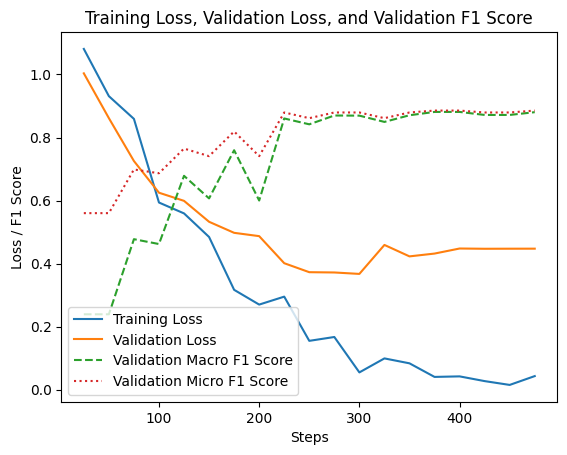

In [12]:
import matplotlib.pyplot as plt

# Extract training loss, validation loss, and F1 score
training_loss = []
validation_loss = []
validation_macro_f1 = []
validation_micro_f1 = []
eval_steps = []
train_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        training_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log:
        validation_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_macro_f1" in log:
        validation_macro_f1.append(log["eval_macro_f1"])
    if "eval_micro_f1" in log:
        validation_micro_f1.append(log["eval_micro_f1"])

# Plot the training and validation loss
plt.plot(train_steps, training_loss, label="Training Loss")
plt.plot(eval_steps, validation_loss, label="Validation Loss")
plt.plot(eval_steps, validation_macro_f1, label="Validation Macro F1 Score", linestyle="--")
plt.plot(eval_steps, validation_micro_f1, label="Validation Micro F1 Score", linestyle="dotted")

# Set labels and title
plt.xlabel("Steps")
plt.ylabel("Loss / F1 Score")
plt.title("Training Loss, Validation Loss, and Validation F1 Score")
plt.legend()
plt.show()


In [13]:
#use to save files to save
from google.colab import drive
drive.mount('/content/drive')
!cp -r {experiment_full_path} /content/drive/MyDrive

Mounted at /content/drive


In [14]:
predictions = trainer.predict(tokenized_datasets["test"])

# Extract logits and true labels
logits = predictions.predictions #(shape: [n_samples, n_classes])
true_labels = predictions.label_ids #(shape: [n_samples])
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # Shape: (n_samples, n_classes)

# Compute the F1 score using your compute_metrics function
f1_score = compute_metrics((logits, true_labels))

# Print the F1 score
f1_score

{'f1_class_0': 0.782608695652174,
 'f1_class_1': 0.9454545454545454,
 'f1_class_2': 0.9263157894736842,
 'macro_f1': 0.8847930101934679,
 'micro_f1': 0.8980891719745223}

In [15]:
true_labels

array([2, 1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 0, 2, 1, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 0, 2, 2,
       0, 2, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0,
       2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 0,
       2, 1, 2])

In [16]:
probabilities

array([[0.7396138 , 0.02653548, 0.23385076],
       [0.25718546, 0.71859807, 0.02421645],
       [0.07242311, 0.00562756, 0.9219494 ],
       [0.00325361, 0.00239203, 0.99435437],
       [0.00127221, 0.00223852, 0.9964893 ],
       [0.9668521 , 0.02316296, 0.00998484],
       [0.10088456, 0.86635375, 0.03276171],
       [0.12888853, 0.8115643 , 0.05954722],
       [0.00210693, 0.00335178, 0.99454135],
       [0.22288556, 0.02962382, 0.7474907 ],
       [0.8276945 , 0.13761269, 0.03469286],
       [0.00127684, 0.0022241 , 0.99649906],
       [0.38322327, 0.59660417, 0.02017261],
       [0.00121153, 0.00265343, 0.9961351 ],
       [0.90414405, 0.07898663, 0.01686935],
       [0.00130514, 0.00225337, 0.9964414 ],
       [0.00648185, 0.02600549, 0.9675127 ],
       [0.00550233, 0.0027326 , 0.9917651 ],
       [0.00212284, 0.00174718, 0.99613   ],
       [0.00118976, 0.00300352, 0.9958067 ],
       [0.12371664, 0.8331073 , 0.04317609],
       [0.312098  , 0.02964574, 0.65825623],
       [0.

In [18]:
def calculate_ece(y_true, y_prob, num_bins=10):
    """Compute Expected Calibration Error (ECE)"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)
    ece = np.sum(np.abs(prob_pred - prob_true) * len(y_true) / num_bins)
    return ece

def plot_reliability_diagram(y_true, y_prob, class_idx, num_bins=10):
    """Plot reliability diagram for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram for Class {class_idx}')
    plt.legend()
    plt.show()

def plot_reliability_diagram_with_bars(y_true, y_prob, class_idx, num_bins=10):
    """Plot reliability diagram with bars for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)

    # Ensure the lengths of prob_true and prob_pred match
    if len(prob_true) != len(prob_pred):
        min_len = min(len(prob_true), len(prob_pred))
        prob_true = prob_true[:min_len]
        prob_pred = prob_pred[:min_len]

    # Plot the reliability diagram with bars
    plt.figure(figsize=(8, 6))
    plt.bar(prob_pred, prob_true, width=0.1, edgecolor='k', alpha=0.7, label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram with Bars for Class {class_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

For a three-label classification problem, you can calculate the reliability diagram and Expected Calibration Error (ECE) for each class by treating the problem as multiple binary classification tasks (one-vs-rest for each class). This is typically done by transforming the problem into three binary sub-problems, one for each class.



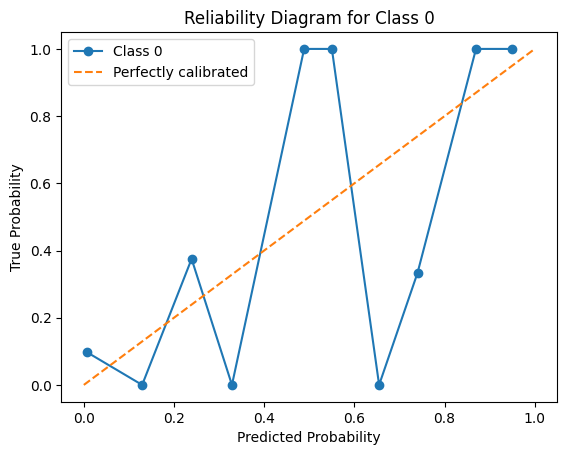

Expected Calibration Error (ECE) for Class 0: 45.335449094435496


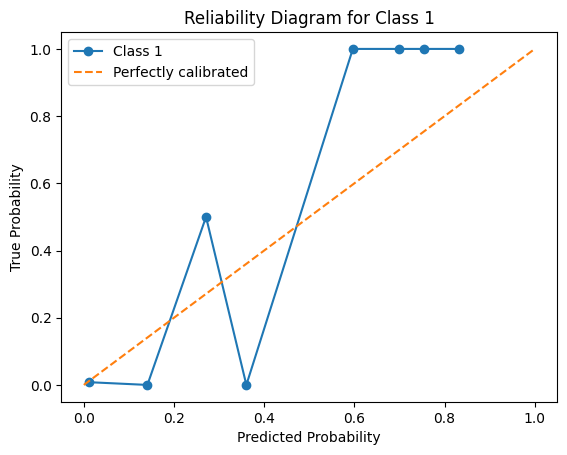

Expected Calibration Error (ECE) for Class 1: 29.068196388458254


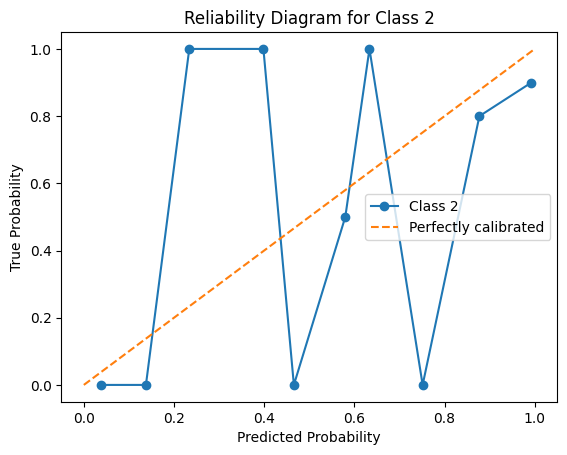

Expected Calibration Error (ECE) for Class 2: 53.00757729390539


In [19]:
bins=10

# Loop over each class (0, 1, 2) and calculate reliability diagram and ECE
for class_idx in range(n_classes):
    # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
    y_true_binary = (true_labels == class_idx).astype(int)

    # Extract probabilities for the current class
    y_prob = probabilities[:, class_idx]

    # Plot reliability diagram for the current class
    plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)
    #plot_reliability_diagram_with_bars(y_true_binary, y_prob, class_idx, num_bins=bins)

    # Calculate and print ECE for the current class
    ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
    print(f"Expected Calibration Error (ECE) for Class {class_idx}: {ece}")



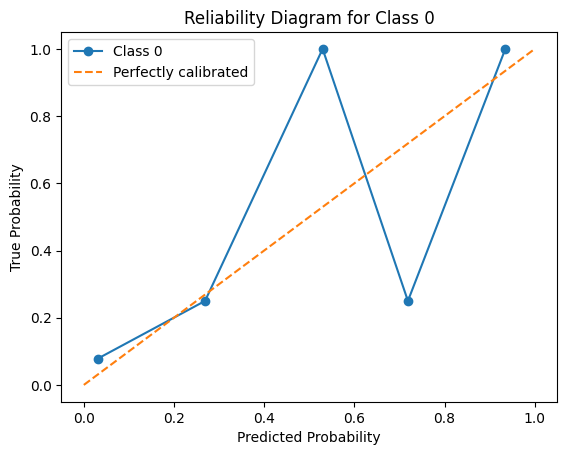

Expected Calibration Error (ECE) for Class 0: 33.61514265063415


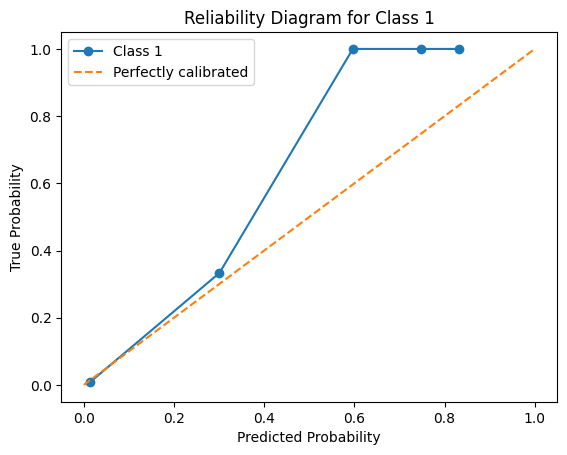

Expected Calibration Error (ECE) for Class 1: 27.006134952131546


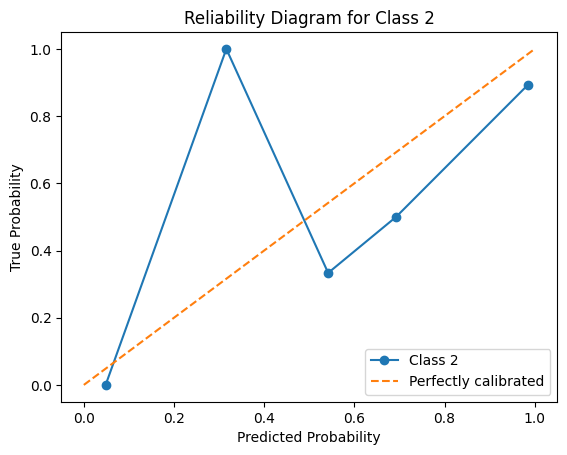

Expected Calibration Error (ECE) for Class 2: 38.4642492404452


In [20]:
bins=5

# Loop over each class (0, 1, 2) and calculate reliability diagram and ECE
for class_idx in range(n_classes):
    # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
    y_true_binary = (true_labels == class_idx).astype(int)

    # Extract probabilities for the current class
    y_prob = probabilities[:, class_idx]

    # Plot reliability diagram for the current class
    plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)
    #plot_reliability_diagram_with_bars(y_true_binary, y_prob, class_idx, num_bins=bins)

    # Calculate and print ECE for the current class
    ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
    print(f"Expected Calibration Error (ECE) for Class {class_idx}: {ece}")





Calcul de l'ECE pour bins=2


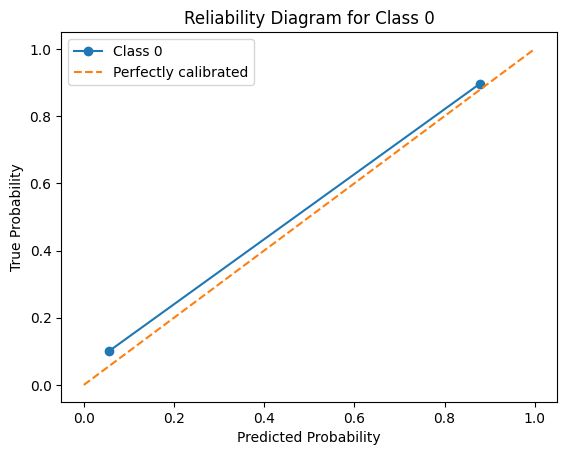

Expected Calibration Error (ECE) for Class 0 with bins=2: 4.9304375229108155


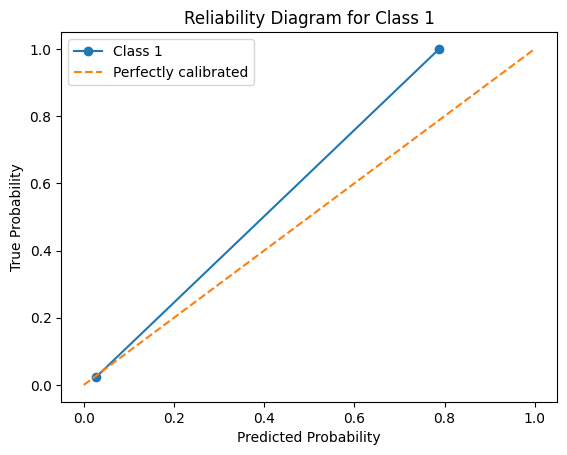

Expected Calibration Error (ECE) for Class 1 with bins=2: 16.93704274840717


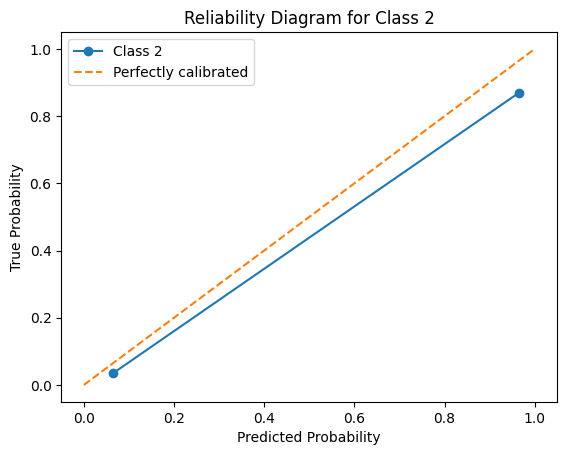

Expected Calibration Error (ECE) for Class 2 with bins=2: 9.8511433594834
Calcul de l'ECE pour bins=3


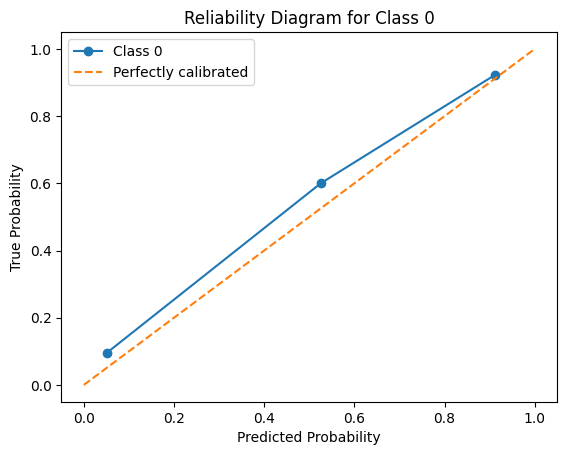

Expected Calibration Error (ECE) for Class 0 with bins=3: 6.792141763353975


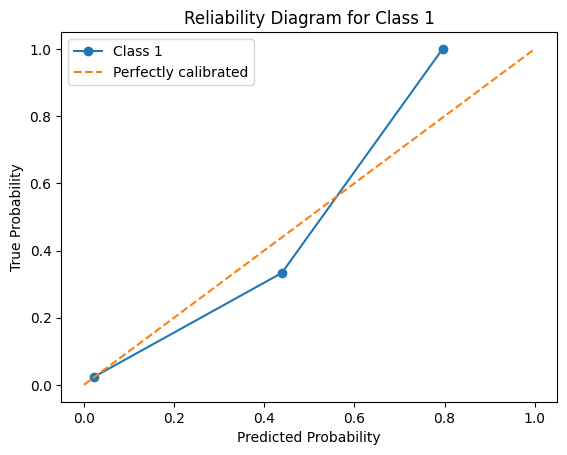

Expected Calibration Error (ECE) for Class 1 with bins=3: 16.317853909968882


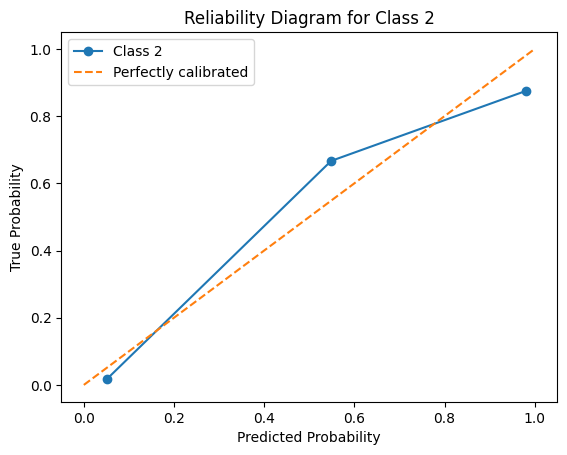

Expected Calibration Error (ECE) for Class 2 with bins=3: 13.460299680003834
Calcul de l'ECE pour bins=4


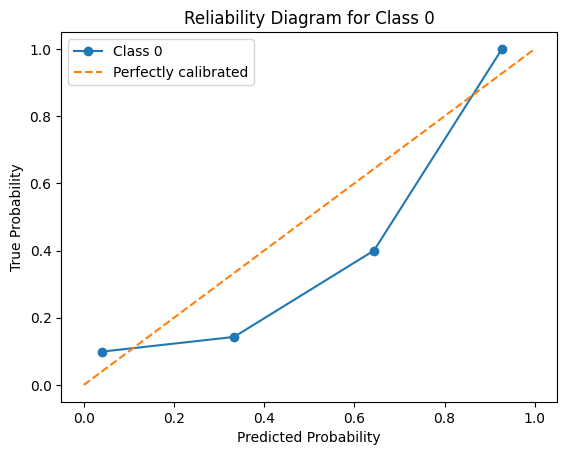

Expected Calibration Error (ECE) for Class 0 with bins=4: 22.163668284416886


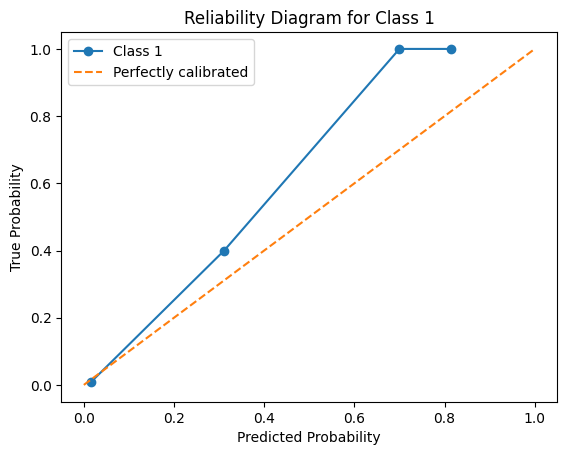

Expected Calibration Error (ECE) for Class 1 with bins=4: 22.837536720292306


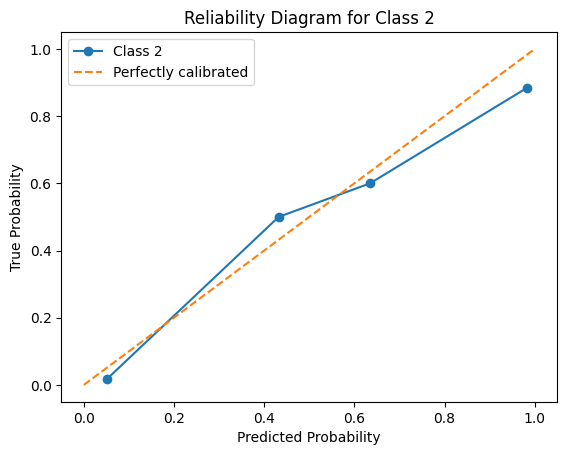

Expected Calibration Error (ECE) for Class 2 with bins=4: 9.224524566149519
Calcul de l'ECE pour bins=5


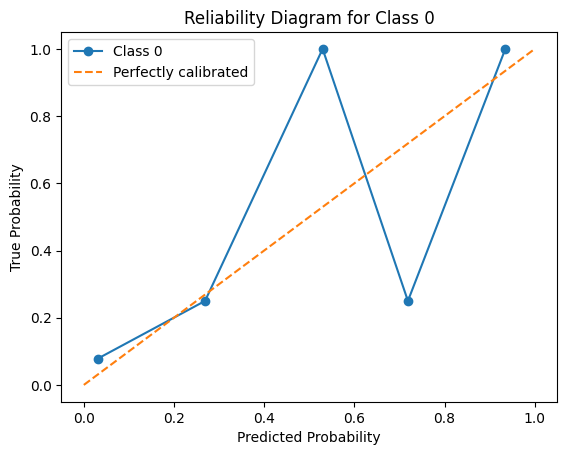

Expected Calibration Error (ECE) for Class 0 with bins=5: 33.61514265063415


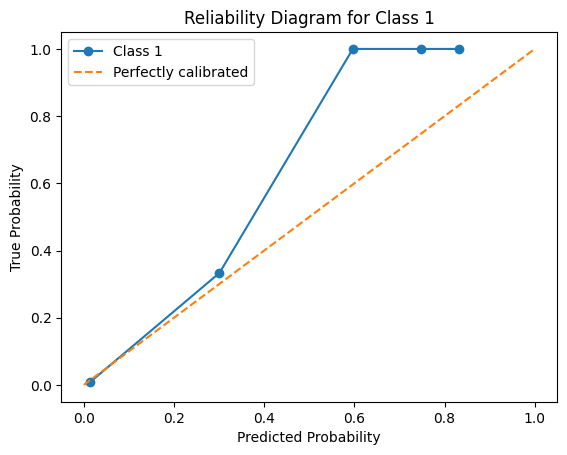

Expected Calibration Error (ECE) for Class 1 with bins=5: 27.006134952131546


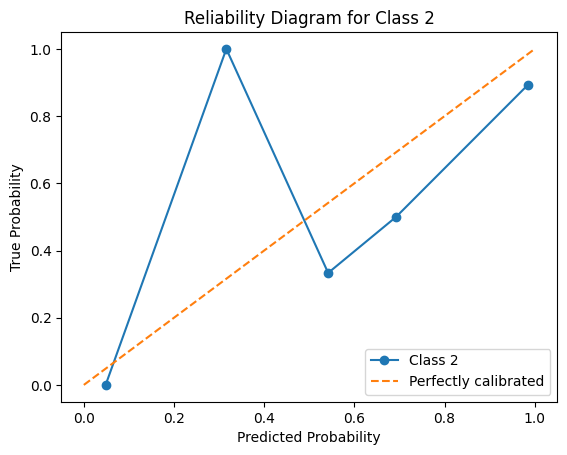

Expected Calibration Error (ECE) for Class 2 with bins=5: 38.4642492404452
Calcul de l'ECE pour bins=6


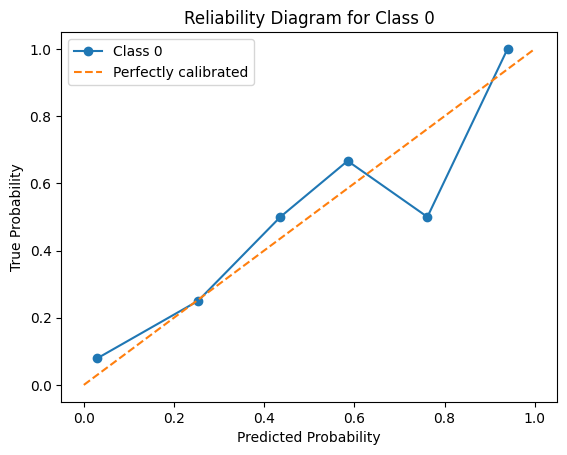

Expected Calibration Error (ECE) for Class 0 with bins=6: 13.62472125015472


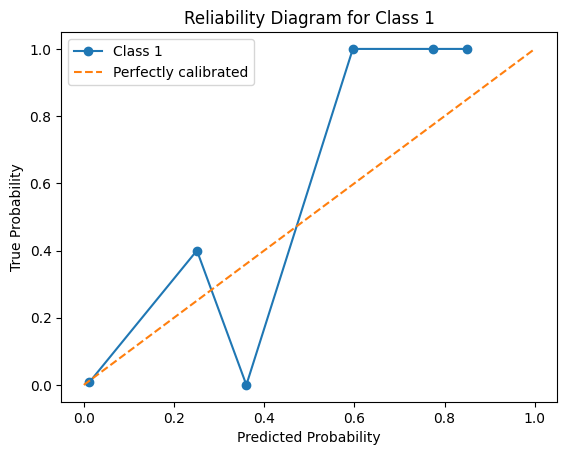

Expected Calibration Error (ECE) for Class 1 with bins=6: 33.83892730424958


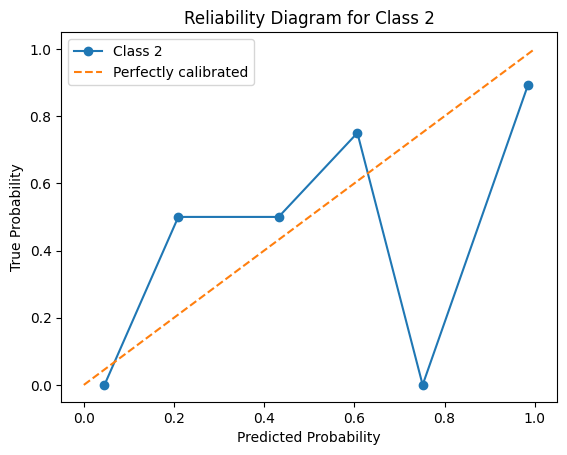

Expected Calibration Error (ECE) for Class 2 with bins=6: 36.38905759660301
Calcul de l'ECE pour bins=7


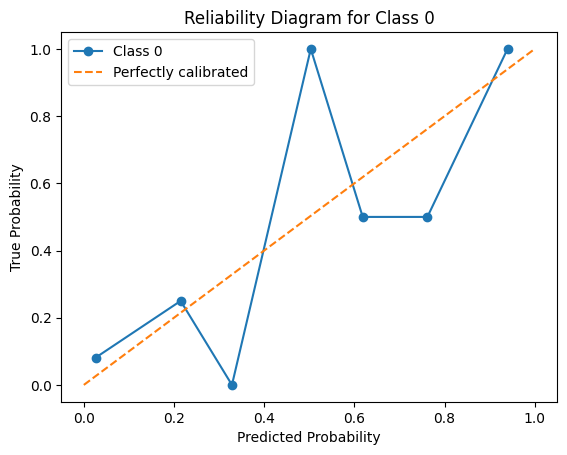

Expected Calibration Error (ECE) for Class 0 with bins=7: 30.41959784074452


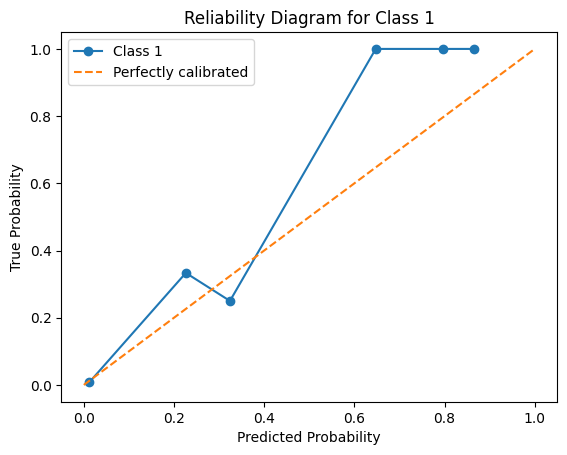

Expected Calibration Error (ECE) for Class 1 with bins=7: 19.618391692158312


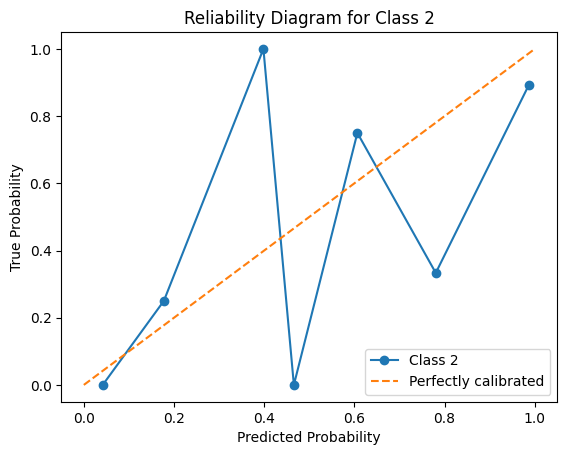

Expected Calibration Error (ECE) for Class 2 with bins=7: 41.87257854694232
Calcul de l'ECE pour bins=8


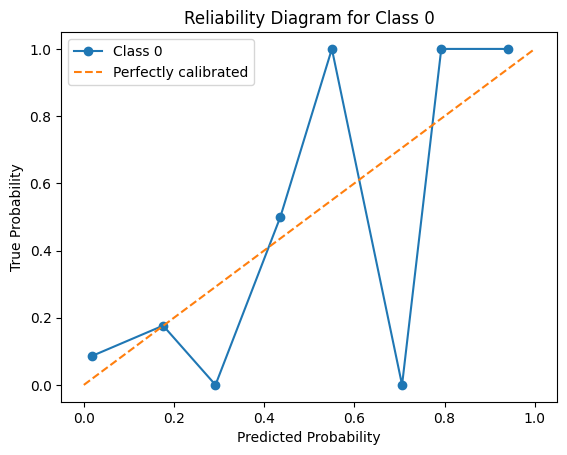

Expected Calibration Error (ECE) for Class 0 with bins=8: 36.26177438781909


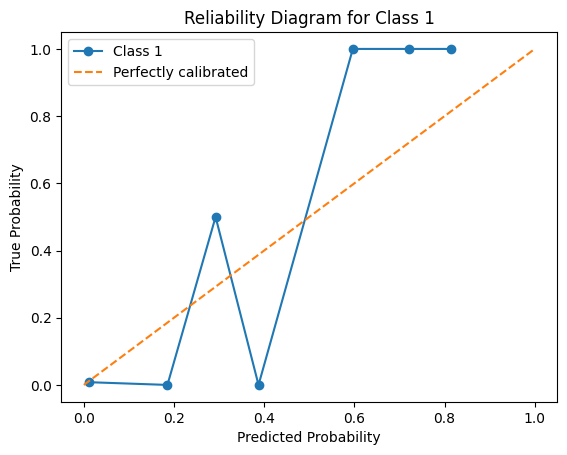

Expected Calibration Error (ECE) for Class 1 with bins=8: 32.42414398829202


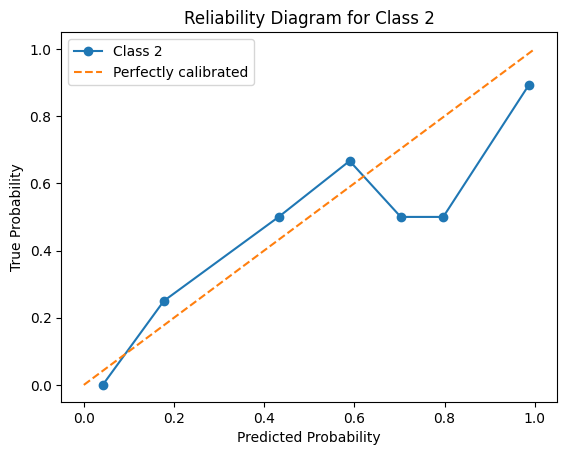

Expected Calibration Error (ECE) for Class 2 with bins=8: 16.758058155425807
Calcul de l'ECE pour bins=9


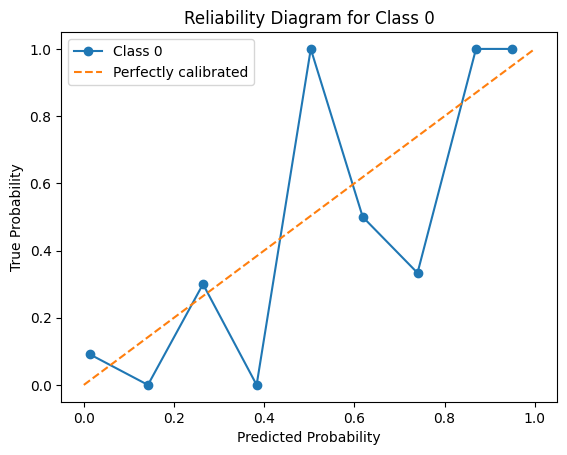

Expected Calibration Error (ECE) for Class 0 with bins=9: 32.134876057657856


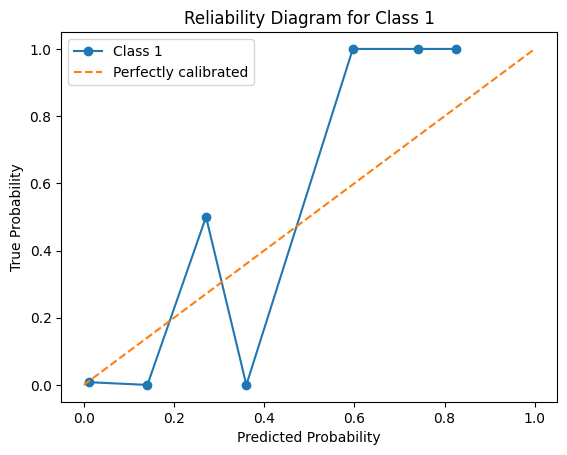

Expected Calibration Error (ECE) for Class 1 with bins=9: 27.36072652678041


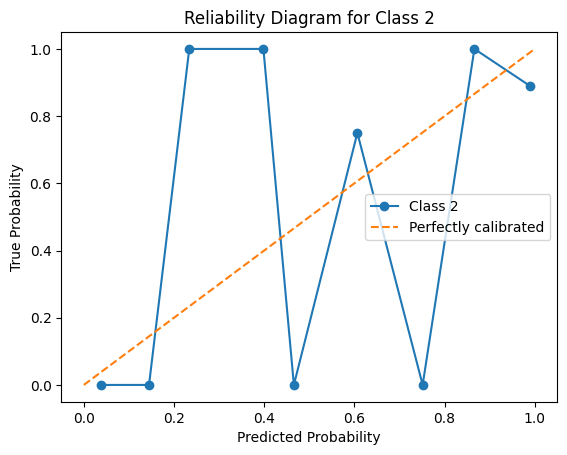

Expected Calibration Error (ECE) for Class 2 with bins=9: 54.85463692960131
Calcul de l'ECE pour bins=10


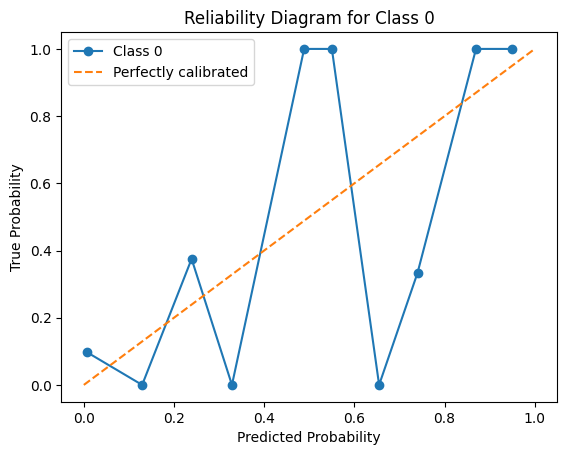

Expected Calibration Error (ECE) for Class 0 with bins=10: 45.335449094435496


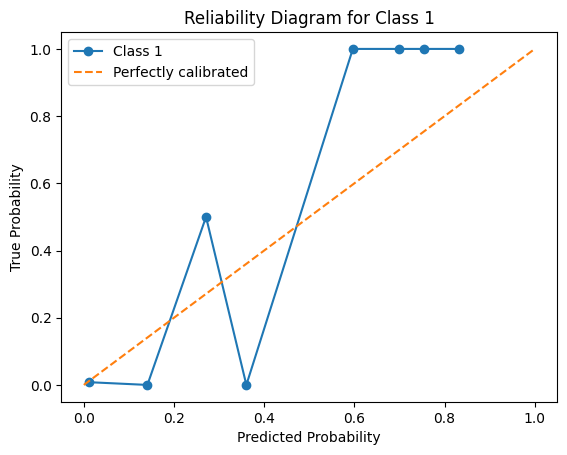

Expected Calibration Error (ECE) for Class 1 with bins=10: 29.068196388458254


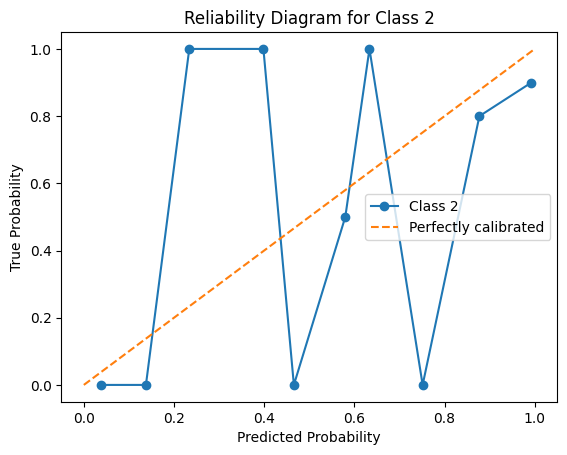

Expected Calibration Error (ECE) for Class 2 with bins=10: 53.00757729390539
Résultats ECE pour chaque classe et chaque valeur de bins:
Class 0, Bins 2: ECE = 4.9304375229108155
Class 0, Bins 3: ECE = 6.792141763353975
Class 0, Bins 4: ECE = 22.163668284416886
Class 0, Bins 5: ECE = 33.61514265063415
Class 0, Bins 6: ECE = 13.62472125015472
Class 0, Bins 7: ECE = 30.41959784074452
Class 0, Bins 8: ECE = 36.26177438781909
Class 0, Bins 9: ECE = 32.134876057657856
Class 0, Bins 10: ECE = 45.335449094435496
Class 1, Bins 2: ECE = 16.93704274840717
Class 1, Bins 3: ECE = 16.317853909968882
Class 1, Bins 4: ECE = 22.837536720292306
Class 1, Bins 5: ECE = 27.006134952131546
Class 1, Bins 6: ECE = 33.83892730424958
Class 1, Bins 7: ECE = 19.618391692158312
Class 1, Bins 8: ECE = 32.42414398829202
Class 1, Bins 9: ECE = 27.36072652678041
Class 1, Bins 10: ECE = 29.068196388458254
Class 2, Bins 2: ECE = 9.8511433594834
Class 2, Bins 3: ECE = 13.460299680003834
Class 2, Bins 4: ECE = 9.224524566

In [21]:
# Initialize a dictionary to save ECE for each class and each value of bins
ece_results = {class_idx: {} for class_idx in range(n_classes)}

# Loop over the values of bins from 2 to 10
for bins in range(2, 11):
    print(f"Calculating ECE for bins={bins}")

    # Loop over each class (0, 1, 2)
    for class_idx in range(n_classes):
        # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
        y_true_binary = (true_labels == class_idx).astype(int)

        # Extract probabilities for the current class
        y_prob = probabilities[:, class_idx]

        # Plot reliability diagram for the current class
        plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)

        # Calculate the ECE for the current class and bin count
        ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
        print(f"Expected Calibration Error (ECE) for Class {class_idx} with bins={bins}: {ece}")

        # Save the ECE in the dictionary
        ece_results[class_idx][bins] = ece

# Display or access the saved results in ece_results
print("ECE results for each class and each value of bins:")
for class_idx, ece_per_bin in ece_results.items():
    for bin_count, ece_value in ece_per_bin.items():
        print(f"Class {class_idx}, Bins {bin_count}: ECE = {ece_value}")


In [22]:
#using strategy = "quantile" strategy{‘uniform’, ‘quantile’}
def calculate_ece(y_true, y_prob, num_bins=10):
    """Compute Expected Calibration Error (ECE)"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = "quantile")
    ece = np.sum(np.abs(prob_pred - prob_true) * len(y_true) / num_bins)
    return ece

def plot_reliability_diagram(y_true, y_prob, class_idx, num_bins=10):
    """Plot reliability diagram for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = "quantile")
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram for Class {class_idx}')
    plt.legend()
    plt.show()

Calculating ECE for bins=2


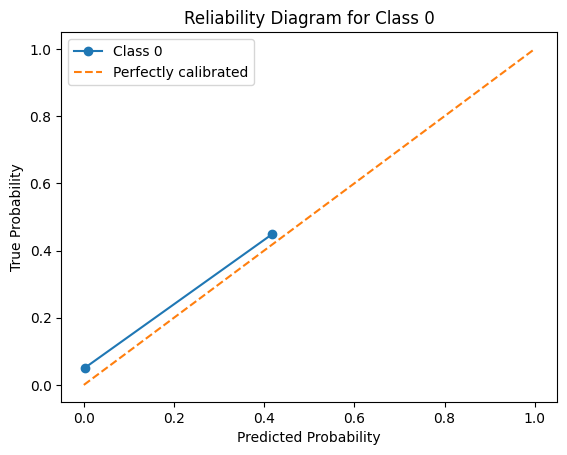

Expected Calibration Error (ECE) for Class 0 with bins=2: 6.242345343081405


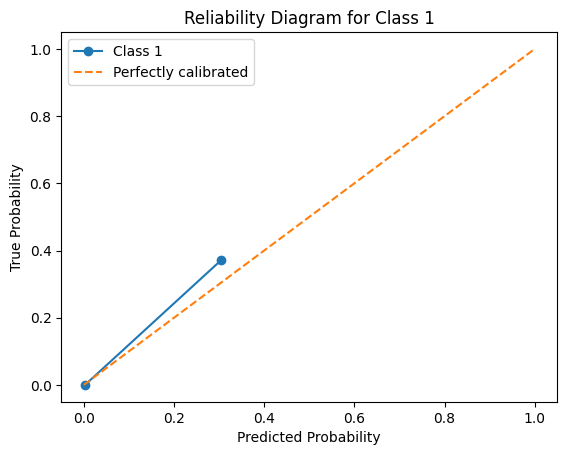

Expected Calibration Error (ECE) for Class 1 with bins=2: 5.453721005732637


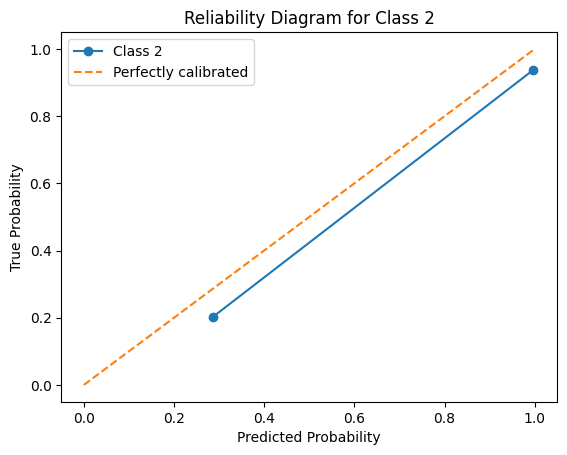

Expected Calibration Error (ECE) for Class 2 with bins=2: 11.246298336078276
Calculating ECE for bins=3


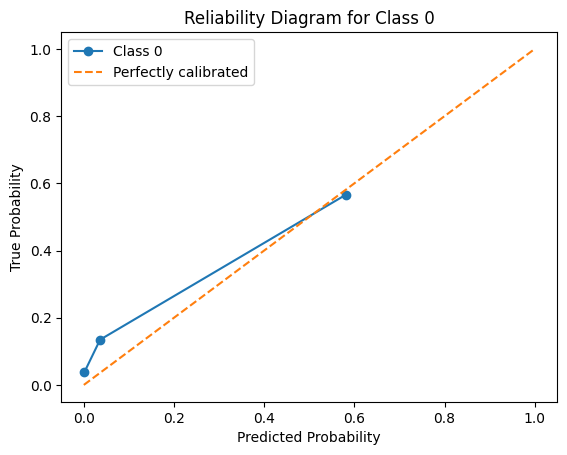

Expected Calibration Error (ECE) for Class 0 with bins=3: 7.882925179381878


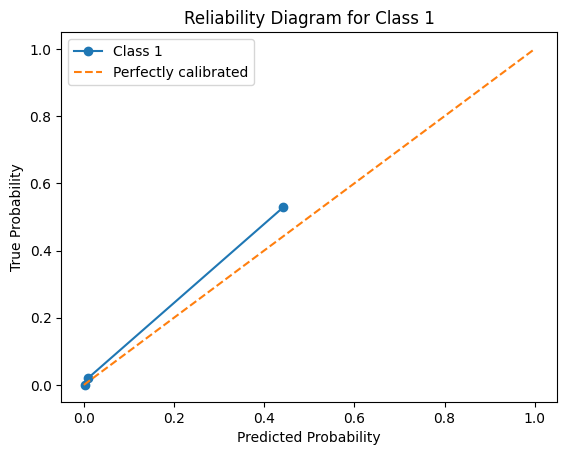

Expected Calibration Error (ECE) for Class 1 with bins=3: 5.202087347847037


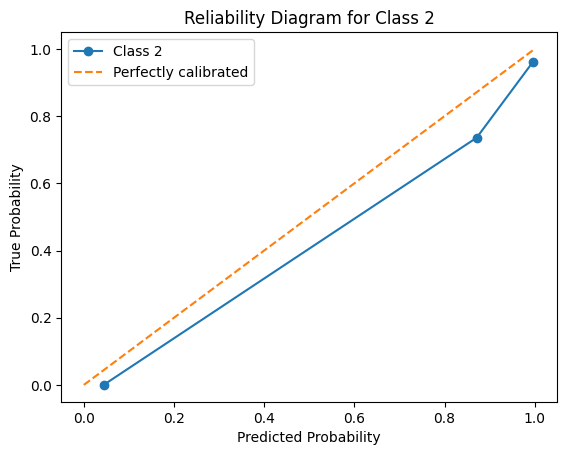

Expected Calibration Error (ECE) for Class 2 with bins=3: 11.194386957355777
Calculating ECE for bins=4


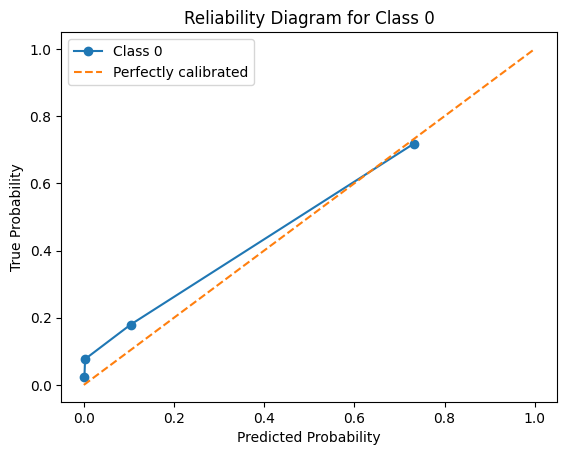

Expected Calibration Error (ECE) for Class 0 with bins=4: 7.355765768034477


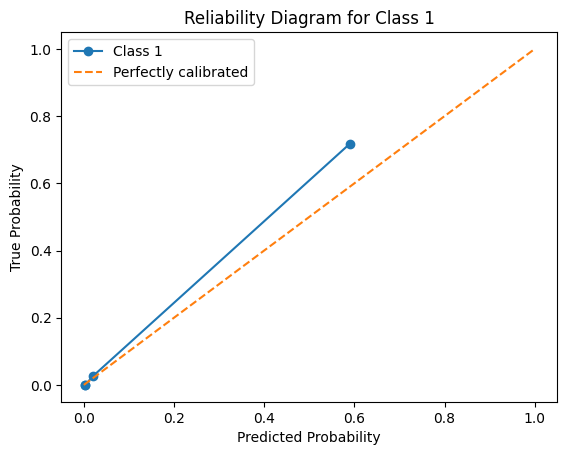

Expected Calibration Error (ECE) for Class 1 with bins=4: 5.45421298035114


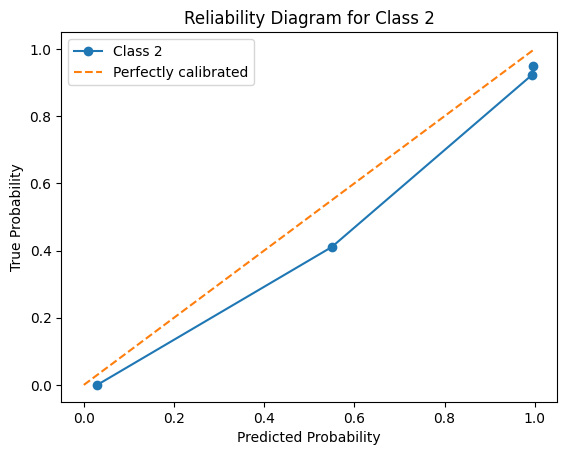

Expected Calibration Error (ECE) for Class 2 with bins=4: 11.300839805185573
Calculating ECE for bins=5


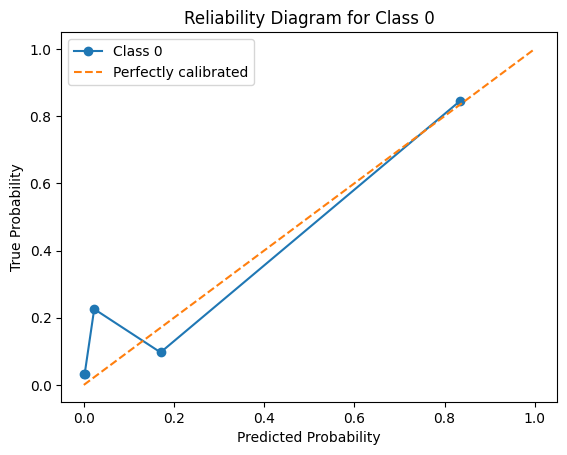

Expected Calibration Error (ECE) for Class 0 with bins=5: 10.899628514388759


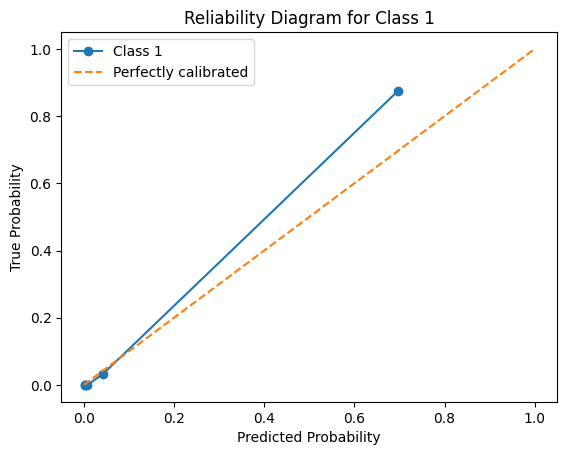

Expected Calibration Error (ECE) for Class 1 with bins=5: 6.302310308781307


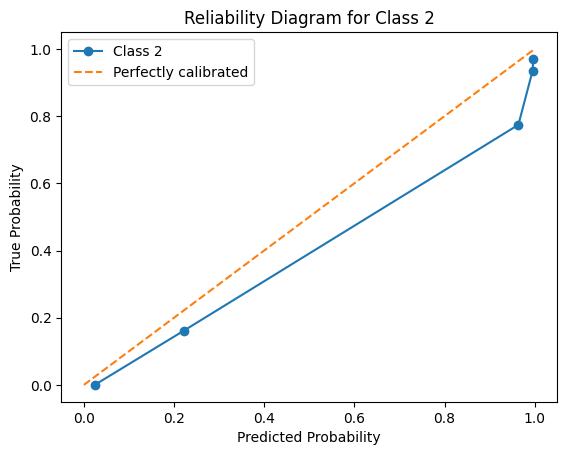

Expected Calibration Error (ECE) for Class 2 with bins=5: 11.351360371940766
Calculating ECE for bins=6


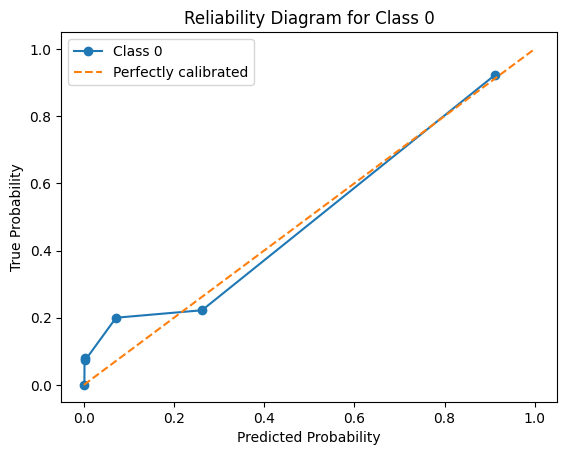

Expected Calibration Error (ECE) for Class 0 with bins=6: 8.624659214165602


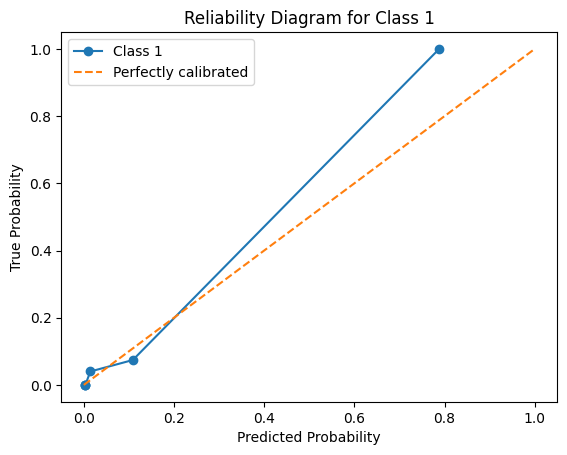

Expected Calibration Error (ECE) for Class 1 with bins=6: 7.32179368506924


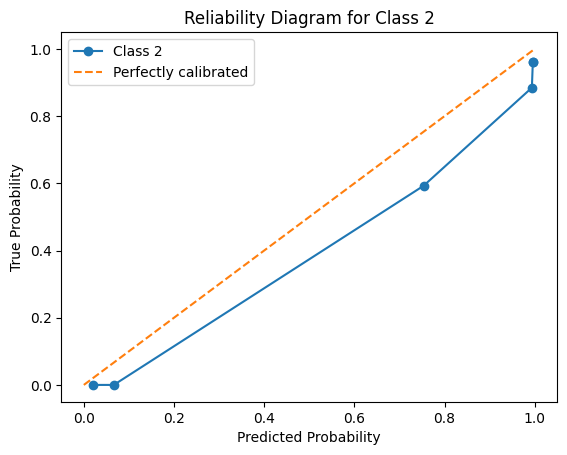

Expected Calibration Error (ECE) for Class 2 with bins=6: 11.168828110464215
Calculating ECE for bins=7


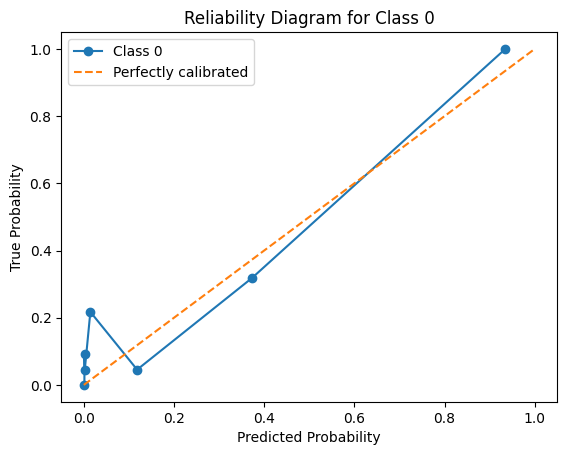

Expected Calibration Error (ECE) for Class 0 with bins=7: 11.875975129937814


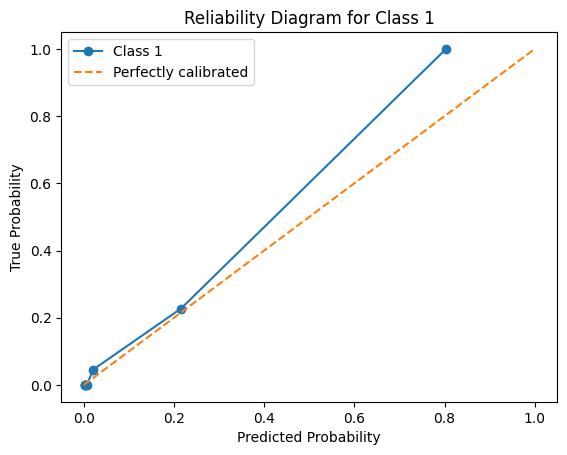

Expected Calibration Error (ECE) for Class 1 with bins=7: 5.555067831033


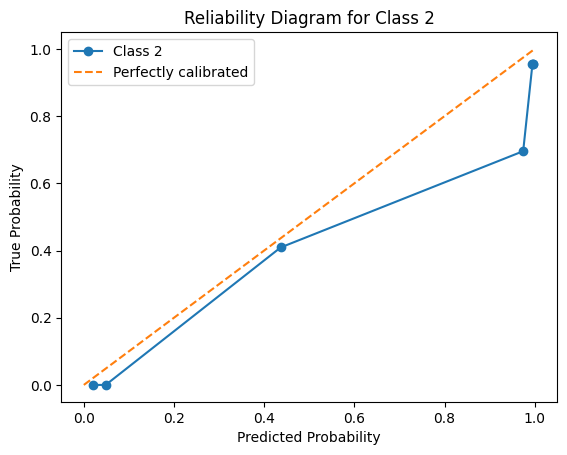

Expected Calibration Error (ECE) for Class 2 with bins=7: 11.132516389985614
Calculating ECE for bins=8


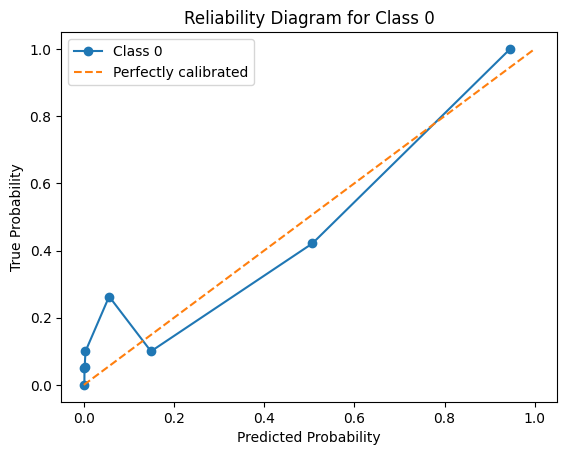

Expected Calibration Error (ECE) for Class 0 with bins=8: 11.641020012971806


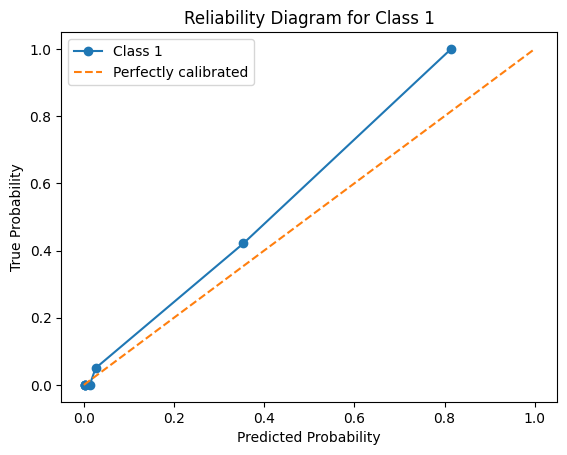

Expected Calibration Error (ECE) for Class 1 with bins=8: 5.891996967050172


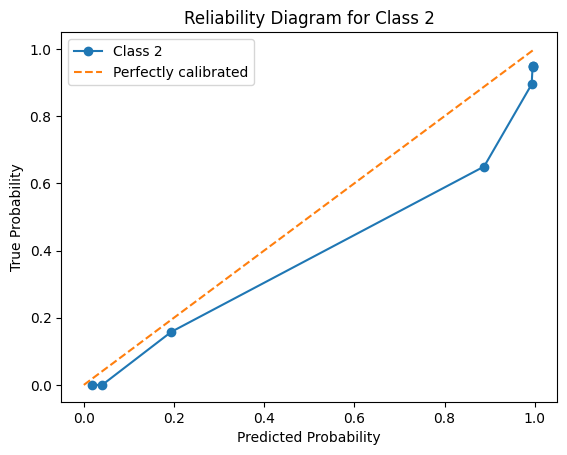

Expected Calibration Error (ECE) for Class 2 with bins=8: 11.22720251873007
Calculating ECE for bins=9


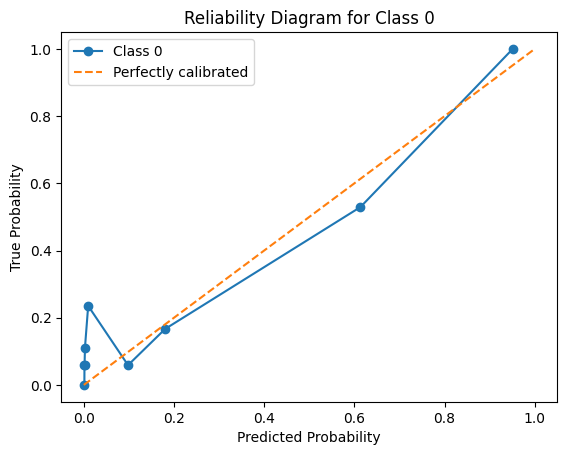

Expected Calibration Error (ECE) for Class 0 with bins=9: 11.093178985308873


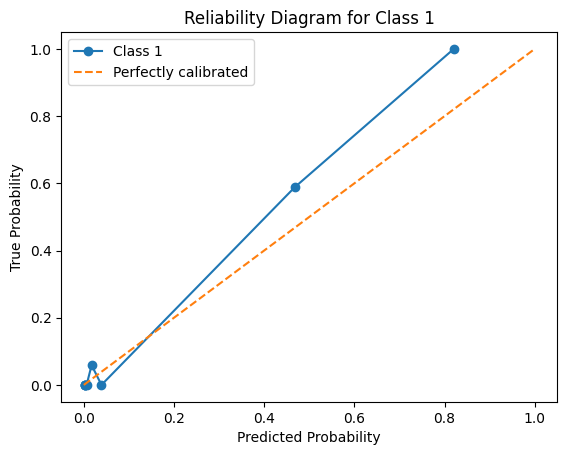

Expected Calibration Error (ECE) for Class 1 with bins=9: 6.922128200198541


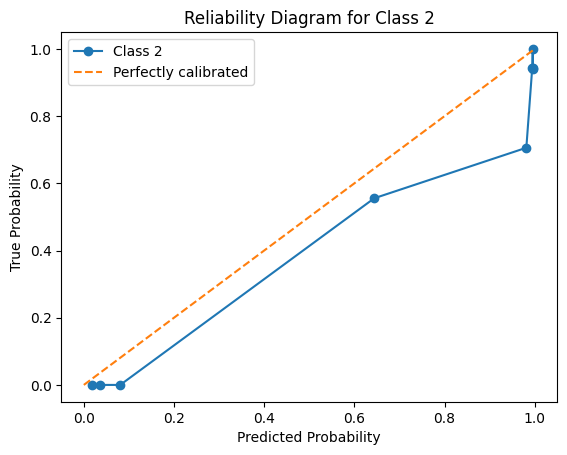

Expected Calibration Error (ECE) for Class 2 with bins=9: 11.492520890121883
Calculating ECE for bins=10


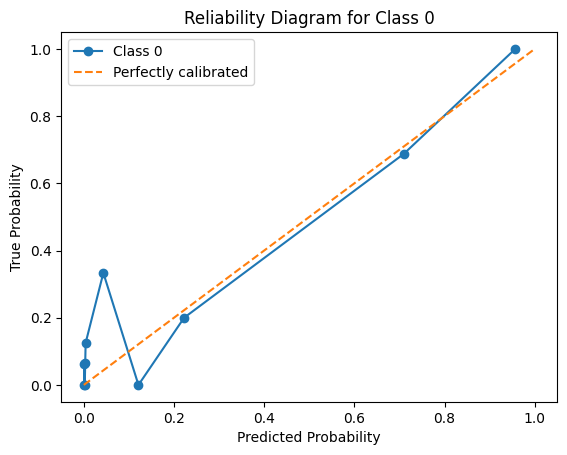

Expected Calibration Error (ECE) for Class 0 with bins=10: 11.762693156984799


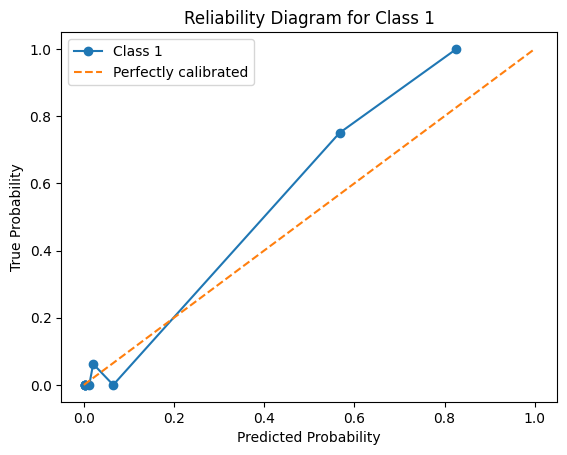

Expected Calibration Error (ECE) for Class 1 with bins=10: 7.672203865296179


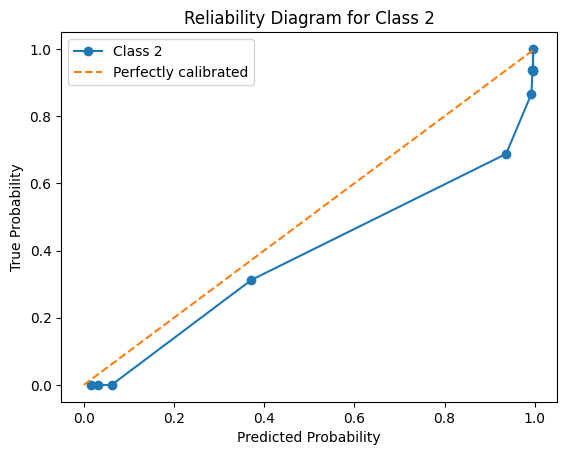

Expected Calibration Error (ECE) for Class 2 with bins=10: 11.409916934592571
ECE results for each class and each value of bins:
Class 0, Bins 2: ECE = 6.242345343081405
Class 0, Bins 3: ECE = 7.882925179381878
Class 0, Bins 4: ECE = 7.355765768034477
Class 0, Bins 5: ECE = 10.899628514388759
Class 0, Bins 6: ECE = 8.624659214165602
Class 0, Bins 7: ECE = 11.875975129937814
Class 0, Bins 8: ECE = 11.641020012971806
Class 0, Bins 9: ECE = 11.093178985308873
Class 0, Bins 10: ECE = 11.762693156984799
Class 1, Bins 2: ECE = 5.453721005732637
Class 1, Bins 3: ECE = 5.202087347847037
Class 1, Bins 4: ECE = 5.45421298035114
Class 1, Bins 5: ECE = 6.302310308781307
Class 1, Bins 6: ECE = 7.32179368506924
Class 1, Bins 7: ECE = 5.555067831033
Class 1, Bins 8: ECE = 5.891996967050172
Class 1, Bins 9: ECE = 6.922128200198541
Class 1, Bins 10: ECE = 7.672203865296179
Class 2, Bins 2: ECE = 11.246298336078276
Class 2, Bins 3: ECE = 11.194386957355777
Class 2, Bins 4: ECE = 11.300839805185573
Class

In [23]:
# Initialize a dictionary to save ECE for each class and each value of bins
ece_results = {class_idx: {} for class_idx in range(n_classes)}

# Loop over the values of bins from 2 to 10
for bins in range(2, 11):
    print(f"Calculating ECE for bins={bins}")

    # Loop over each class (0, 1, 2)
    for class_idx in range(n_classes):
        # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
        y_true_binary = (true_labels == class_idx).astype(int)

        # Extract probabilities for the current class
        y_prob = probabilities[:, class_idx]

        # Plot reliability diagram for the current class
        plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)

        # Calculate the ECE for the current class and bin count
        ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
        print(f"Expected Calibration Error (ECE) for Class {class_idx} with bins={bins}: {ece}")

        # Save the ECE in the dictionary
        ece_results[class_idx][bins] = ece

# Display or access the saved results in ece_results
print("ECE results for each class and each value of bins:")
for class_idx, ece_per_bin in ece_results.items():
    for bin_count, ece_value in ece_per_bin.items():
        print(f"Class {class_idx}, Bins {bin_count}: ECE = {ece_value}")
